In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [119]:
from tqdm import tqdm

In [120]:
torch.set_default_dtype(torch.float64)

# Load data


In [121]:
from scipy import signal
from scipy.fftpack import diff as psdiff
from scipy.integrate import solve_ivp


class AbstractODETarget:
    def __init__(self, dt=1e-3, t_step=0.25, dim=2):
        self.dim = dim
        self.dt = dt
        self.t_step = t_step
        self.n_step = int(t_step / dt)

    def generate_init_data(self, n_traj, traj_len, seed=None):
        data_x = []
        if seed is not None:
            np.random.seed(seed)

        x0 = np.random.uniform(size=(n_traj, self.dim), low=self.x_min, high=self.x_max)

        data_x.append(x0)
        for t in range(traj_len - 1):
            data_x.append(self.euler(data_x[t]))

        data_x = np.asarray(data_x)

        data_x = np.transpose(data_x, [1,0,2]).reshape(n_traj * traj_len, self.dim)
        return np.asarray(data_x)

    def generate_next_data(self, data_x):
        data_y = self.euler(data_x)
        return data_y

    def generate_data(self, n_traj, traj_len, seed=None):
        data_x = []
        if seed is not None:
            np.random.seed(seed)

        x0 = np.random.uniform(size=(n_traj, self.dim), low=self.x_min, high=self.x_max)

        data_x.append(x0)
        for t in range(traj_len - 1):
            data_x.append(self.euler(data_x[t]))

        data_x = np.asarray(data_x)
        data_x = np.transpose(data_x, [1,0,2])
        return np.asarray(data_x)

    def rhs(self):
        """RHS Function :return: The rhs of one specific ODE."""
        return NotImplementedError

    def euler(self, x):
        """ODE Solver.

        :param x: variable
        :type x: vector (float)
        :return: ODE Solution at t_step after iterating the Euler method n_step times
        :rtype: vector with the same shape as the variable x (float)
        """
        for _ in range(self.n_step):
            x = x + self.dt * self.rhs(x)
        return x


class DuffingOscillator(AbstractODETarget):
    """Duffing equation based on the notation in.

    (https://en.wikipedia.org/wiki/Duffing_equation)
    """

    def __init__(self, dt=1e-3, t_step=0.25, dim=2, delta=0.5, alpha=1.0, beta=-1.0):
        super().__init__(dt, t_step, dim)
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.x_min = -2
        self.x_max = 2

    def rhs(self, x):
        x1 = x[:, 0].reshape(x.shape[0], 1)
        x2 = x[:, 1].reshape(x.shape[0], 1)
        f1 = x2
        f2 = -self.delta * x2 - x1 * (self.beta + self.alpha * x1**2)
        return np.concatenate([f1, f2], axis=-1)
    


In [122]:
duffing = DuffingOscillator(dt=1e-3, t_step=0.25, dim=2, delta=0.5, alpha=1.0, beta=-1.0)
duffing_data_curr = duffing.generate_init_data(n_traj=1000, traj_len=50, seed=625)
duffing_data_next = duffing.generate_next_data(duffing_data_curr)
duffing_data_curr = torch.tensor(duffing_data_curr).double()
duffing_data_next = torch.tensor(duffing_data_next).double()

In [123]:
N = 1000
L = 50
state_dim = 2
d = state_dim

In [124]:
duffing_data = duffing.generate_data(n_traj=N, traj_len=L, seed=625)
duffing_data = torch.tensor(duffing_data)

In [125]:
dataset = torch.utils.data.TensorDataset(torch.tensor(duffing_data))

/tmp/ipykernel_2868189/4118435461.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.utils.data.TensorDataset(torch.tensor(duffing_data))


In [126]:
duffing_data.shape

torch.Size([1000, 50, 2])

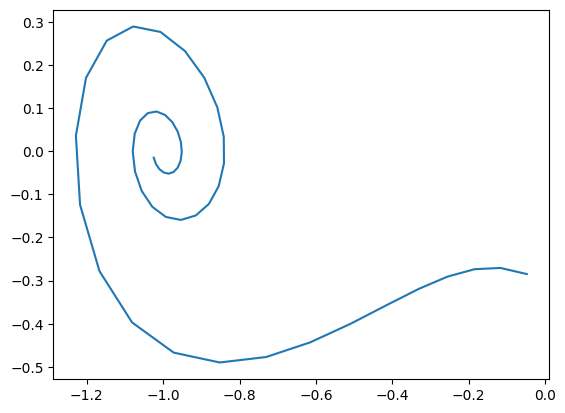

In [127]:
index = 999
plt.plot(duffing_data[index,:,0], duffing_data[index,:,1])

# Build Model Class

## Dictionary Class

In [128]:
class AbstractDictionary:
    def __init__(self, n_psi_train, add_constant=True):
        self.n_psi_train = n_psi_train
        self.add_constant = add_constant

    def generate_B(self, inputs):
        target_dim = inputs.shape[-1]  # Get the last dimension of the input tensor

        if self.add_constant:
            self.n_psi = self.n_psi_train + target_dim + 1
            # Initialize B matrix with zeros
            self.B = torch.zeros((self.n_psi, target_dim), dtype=inputs.dtype, device=inputs.device)
            # Setting the sub-diagonal elements to 1
            for i in range(target_dim):
                self.B[i + 1, i] = 1.0
        else:
            self.basis_func_number = self.n_psi_train + target_dim
            # Initialize B matrix with zeros
            self.B = torch.zeros((self.basis_func_number, target_dim), dtype=inputs.dtype, device=inputs.device)
            # Setting the diagonal elements to 1
            for i in range(target_dim):
                self.B[i, i] = 1.0

        return self.B
class DicNN(nn.Module):
    """Trainable dictionaries."""

    def __init__(self, inputs_dim = 1, layer_sizes=[64, 64], n_psi_train=22, activation_func='tanh'):
        super(DicNN, self).__init__()
        self.inputs_dim = inputs_dim
        self.layer_sizes = layer_sizes
        self.n_psi_train = n_psi_train
        self.activation_func = activation_func
        
        # Creating the input layer
        self.input_layer = nn.Linear(self.inputs_dim, layer_sizes[0], bias=False)
        
        # Creating hidden layers
        self.hidden_layers = nn.ModuleList()
        for in_features, out_features in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.hidden_layers.append(nn.Linear(in_features, out_features))
        
        # Creating the output layer
        self.output_layer = nn.Linear(layer_sizes[-1], n_psi_train)

    def forward(self, inputs):
        # Check layer dimension
        if inputs.shape[-1] != self.inputs_dim:
            print(f"Error: Expected input dimension {self.inputs_dim}, but got {inputs.shape[-1]}")
            return None  # Optionally, you could raise an exception here

        # Apply the input layer
        psi_x_train = self.input_layer(inputs)
        
        # Apply hidden layers with residual connections
        for layer in self.hidden_layers:
            if self.activation_func == 'tanh':
                psi_x_train = psi_x_train + F.tanh(layer(psi_x_train))
            elif self.activation_func == 'relu':
                psi_x_train = psi_x_train + F.relu(layer(psi_x_train))
            else:
                raise ValueError("Unsupported activation function")

        # Apply the output layer
        outputs = self.output_layer(psi_x_train)
        return outputs

class PsiNN(nn.Module, AbstractDictionary):
    def __init__(self, inputs_dim=1, dic_trainable=DicNN, layer_sizes=[64, 64], n_psi_train=22, activation_func='tanh', add_constant=True):
        super(PsiNN, self).__init__()
        self.n_psi_train = n_psi_train
        self.add_constant = add_constant
        # Create an instance of the dic_trainable with given parameters
        self.dicNN = dic_trainable(inputs_dim, layer_sizes, n_psi_train, activation_func) if n_psi_train != 0 else None

    def forward(self, inputs):
        outputs = []

        # Add a constant column of ones
        if self.add_constant:
            constant = torch.ones_like(inputs)[...,[0]]
            outputs.append(constant)

        # Add the original inputs
        outputs.append(inputs)

        # Add the output from dicNN if applicable
        if self.n_psi_train != 0:
            psi_x_train = self.dicNN(inputs)
            outputs.append(psi_x_train)

        # Concatenate along the feature dimension
        outputs = torch.cat(outputs, dim=-1) if len(outputs) > 1 else outputs[0]

        return outputs


## Constant K Class

In [129]:
class ConstantMatrixMultiplier(nn.Module):
    def __init__(self, n_psi, dict_cons=True):
        super(ConstantMatrixMultiplier, self).__init__()
        # Initialize K as a n_spi x n_psi trainable parameter
        self.n_psi = n_psi
        # initial_weights = torch.eye(n_psi)*1/10
        initial_weights = torch.randn(n_psi, n_psi)
        self.K = nn.Parameter(initial_weights)
        self.K.requires_grad = False

    def forward(self, inputs):
        # Perform matrix multiplication
        # inputs should be of shape (batch_size, n_psi)
        # K is (n_psi, n_psi), so the result will be of shape (batch_size, n_psi)
        return torch.matmul(inputs, self.K)


## Koopman Prediction Class

In [130]:
class Koopman_predictor(nn.Module):
    def __init__(self, dict, model_K):
        super(Koopman_predictor, self).__init__()
        self.dict = dict
        self.model_K = model_K

    def forward(self, inputs):
        # Apply dictionary
        psi_x = self.dict(inputs)
        # Apply Koopman operator
        K_psi_x = self.model_K(psi_x)
        return K_psi_x

# Build Data Loader


In [131]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

# Build Model

In [132]:
state_dim = 2
layer_sizes = [256,256,256]
n_psi_train = 22
activation_func = 'tanh'

In [133]:
n_psi = 1 + state_dim + n_psi_train

In [134]:
dict_nn = PsiNN(inputs_dim=state_dim, 
                layer_sizes=layer_sizes, 
                n_psi_train=n_psi_train, 
                activation_func=activation_func)
model_K = ConstantMatrixMultiplier(n_psi=n_psi)

Koopman_model = Koopman_predictor(dict_nn, model_K)

In [135]:
optimizer = torch.optim.Adam(list(Koopman_model.parameters()), lr=1e-2)
loss_function = nn.MSELoss()

In [136]:
# dataset = MyDataset(duffing_data_curr, duffing_data_next)

data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

In [137]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20)

# Train Model

In [138]:
def compute_K(dict, data_x, data_y, reg):
    # Compute representations
    psi_x = dict(data_x)
    psi_y = dict(data_y)
    
    # Transpose psi_x
    psi_xt = psi_x.t()  # Transposing the matrix
    
    # Identity matrix with the same dimension as psi_x
    idmat = torch.eye(psi_x.shape[1], dtype=torch.float64)
    
    # Regularized inverse computation
    xtx = torch.mm(psi_xt, psi_x)  # Matrix multiplication of psi_xt and psi_x
    xtx_inv = torch.pinverse(reg * idmat + xtx)  # Pseudoinverse of regularized matrix
    
    # Matrix multiplication of psi_xt and psi_y
    xty = torch.mm(psi_xt, psi_y)
    
    # Compute the regularized K matrix
    K_reg = torch.mm(xtx_inv, xty)
    
    return K_reg

In [139]:
Koopman_model.dict(duffing_data).shape

torch.Size([1000, 50, 25])

In [143]:
# Number of training epochs
# Koopman_model.to('cuda:0')


num_epochs = 60
loss_history = []
T = 2
for epoch in range(num_epochs):
    loop = tqdm(data_loader, leave=True)
    epoch_losses = []
    for x in loop:
        # x shape: (n_traj, traj_length, state_dim)
        
        # output_pred = Koopman_model(x_curr)

        # output_next = Koopman_model.dict(x_next)

        psi = Koopman_model.dict(x[0])
        target = 0
        for i in range(L-T):
            for j in range(T):
                target += torch.linalg.norm(psi[:,i+j,:]-psi[:,i,:]@torch.matrix_power(Koopman_model.model_K.K, j))
        
        zero = torch.zeros_like(target)
        # Compute the loss
        loss = loss_function(target, zero)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect loss for this batch
        epoch_losses.append(loss.item())

        current_lr = optimizer.param_groups[0]['lr']

        # Update progress bar with current loss.
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), lr=current_lr)

    # Average loss for this epoch
    average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(average_epoch_loss)

    # # Update the weights of model_K with the pinverse method
    # psi_x = dict_nn(duffing_data_curr)
    # psi_y = dict_nn(duffing_data_next)
    # psi_curr_pinv = torch.pinverse(psi_x)
    # K_weights = torch.matmul(psi_curr_pinv, psi_y)
    # model_K.K.data = K_weights

    duffing_data_curr = duffing_data[:,:-1,:]
    duffing_data_next = duffing_data[:,1:,:]
    duffing_data_curr = duffing_data_curr.reshape(-1, duffing_data_curr.shape[-1])
    duffing_data_next = duffing_data_next.reshape(-1, duffing_data_next.shape[-1])



    K_weights = compute_K(Koopman_model.dict, 
                          duffing_data_curr, 
                          duffing_data_next, 
                          reg=0.01)
    Koopman_model.model_K.K.data = K_weights

    # Perform a forward pass with the updated model_K to compute the loss for the epoch
    with torch.no_grad():
        output_curr = Koopman_model.dict(duffing_data[:,:-1,:]).detach()
        output_next = Koopman_model.dict(duffing_data[:,1:,:]).detach()
        output_pred = Koopman_model.model_K(output_curr).detach()
        loss_total = loss_function(output_next, output_pred)

    # Update learning rate based on total loss at the end of epoch
    # scheduler.step(average_epoch_loss)
    scheduler.step(loss_total)


    # Print the loss at the end of each epoch using tqdm.write to avoid breaking the progress bar layout
    tqdm.write(f"Epoch {epoch + 1}/{num_epochs} finished with updated loss: {loss_total.item()}")


Epoch [1/60]: 100%|██████████| 10/10 [00:00<00:00, 21.25it/s, loss=2.2e+5, lr=0.00512]


Epoch 1/60 finished with updated loss: 0.04565476156040807


Epoch [2/60]: 100%|██████████| 10/10 [00:00<00:00, 25.03it/s, loss=1.29e+5, lr=0.00512]


Epoch 2/60 finished with updated loss: 0.04566705756558153


Epoch [3/60]: 100%|██████████| 10/10 [00:00<00:00, 24.92it/s, loss=1.62e+5, lr=0.00512]


Epoch 3/60 finished with updated loss: 0.04567061450805158


Epoch [4/60]: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s, loss=8.15e+4, lr=0.00512]


Epoch 4/60 finished with updated loss: 0.04567119360658099


Epoch [5/60]: 100%|██████████| 10/10 [00:00<00:00, 25.15it/s, loss=1.3e+5, lr=0.00512]


Epoch 5/60 finished with updated loss: 0.04567077833252352


Epoch [6/60]: 100%|██████████| 10/10 [00:00<00:00, 25.07it/s, loss=7.52e+4, lr=0.00512]


Epoch 6/60 finished with updated loss: 0.045670035411206816


Epoch [7/60]: 100%|██████████| 10/10 [00:00<00:00, 25.74it/s, loss=1.24e+5, lr=0.00512]


Epoch 7/60 finished with updated loss: 0.045669096363431944


Epoch [8/60]: 100%|██████████| 10/10 [00:00<00:00, 25.53it/s, loss=1.23e+5, lr=0.00512]


Epoch 8/60 finished with updated loss: 0.045668107549506474


Epoch [9/60]: 100%|██████████| 10/10 [00:00<00:00, 25.89it/s, loss=1.39e+5, lr=0.00512]


Epoch 9/60 finished with updated loss: 0.0456670692257468


Epoch [10/60]: 100%|██████████| 10/10 [00:00<00:00, 24.35it/s, loss=1.48e+5, lr=0.00512]


Epoch 10/60 finished with updated loss: 0.045666065689316984


Epoch [11/60]: 100%|██████████| 10/10 [00:00<00:00, 25.20it/s, loss=1.19e+5, lr=0.00512]


Epoch 11/60 finished with updated loss: 0.0456649892965067


Epoch [12/60]: 100%|██████████| 10/10 [00:00<00:00, 25.16it/s, loss=1.45e+5, lr=0.00512]


Epoch 12/60 finished with updated loss: 0.0456638974087699


Epoch [13/60]: 100%|██████████| 10/10 [00:00<00:00, 24.81it/s, loss=1.72e+5, lr=0.00512]


Epoch 13/60 finished with updated loss: 0.04566284190419093


Epoch [14/60]: 100%|██████████| 10/10 [00:00<00:00, 24.98it/s, loss=1.26e+5, lr=0.00512]


Epoch 14/60 finished with updated loss: 0.04566181189471811


Epoch [15/60]: 100%|██████████| 10/10 [00:00<00:00, 25.24it/s, loss=1.35e+5, lr=0.00512]


Epoch 15/60 finished with updated loss: 0.0456607176827179


Epoch [16/60]: 100%|██████████| 10/10 [00:00<00:00, 25.22it/s, loss=8.7e+4, lr=0.0041]


Epoch 16/60 finished with updated loss: 0.0456598053919406


Epoch [17/60]: 100%|██████████| 10/10 [00:00<00:00, 23.41it/s, loss=1.2e+5, lr=0.0041]


Epoch 17/60 finished with updated loss: 0.04565892243762162


Epoch [18/60]: 100%|██████████| 10/10 [00:00<00:00, 25.29it/s, loss=1.04e+5, lr=0.0041]


Epoch 18/60 finished with updated loss: 0.04565799786552339


Epoch [19/60]: 100%|██████████| 10/10 [00:00<00:00, 25.98it/s, loss=8.55e+4, lr=0.0041]


Epoch 19/60 finished with updated loss: 0.04565712304554895


Epoch [20/60]: 100%|██████████| 10/10 [00:00<00:00, 25.34it/s, loss=1.61e+5, lr=0.0041]


Epoch 20/60 finished with updated loss: 0.04565619696296641


Epoch [21/60]: 100%|██████████| 10/10 [00:00<00:00, 24.23it/s, loss=1.28e+5, lr=0.0041]


Epoch 21/60 finished with updated loss: 0.04565535031886602


Epoch [22/60]: 100%|██████████| 10/10 [00:00<00:00, 25.50it/s, loss=1.46e+5, lr=0.0041]


Epoch 22/60 finished with updated loss: 0.045654434209267694


Epoch [23/60]: 100%|██████████| 10/10 [00:00<00:00, 24.88it/s, loss=1.58e+5, lr=0.0041]


Epoch 23/60 finished with updated loss: 0.045653521464008584


Epoch [24/60]: 100%|██████████| 10/10 [00:00<00:00, 25.54it/s, loss=1.2e+5, lr=0.0041]


Epoch 24/60 finished with updated loss: 0.045652641719957206


Epoch [25/60]: 100%|██████████| 10/10 [00:00<00:00, 25.79it/s, loss=8.93e+4, lr=0.0041]


Epoch 25/60 finished with updated loss: 0.04565170762488471


Epoch [26/60]: 100%|██████████| 10/10 [00:00<00:00, 25.13it/s, loss=1.18e+5, lr=0.0041]


Epoch 26/60 finished with updated loss: 0.04565072026041702


Epoch [27/60]: 100%|██████████| 10/10 [00:00<00:00, 25.81it/s, loss=1.43e+5, lr=0.0041]


Epoch 27/60 finished with updated loss: 0.045649766258145694


Epoch [28/60]: 100%|██████████| 10/10 [00:00<00:00, 25.79it/s, loss=7.77e+4, lr=0.0041]


Epoch 28/60 finished with updated loss: 0.04564884750053037


Epoch [29/60]: 100%|██████████| 10/10 [00:00<00:00, 25.73it/s, loss=1.39e+5, lr=0.0041]


Epoch 29/60 finished with updated loss: 0.04564786243895738


Epoch [30/60]: 100%|██████████| 10/10 [00:00<00:00, 25.50it/s, loss=9.25e+4, lr=0.0041]


Epoch 30/60 finished with updated loss: 0.04564689959805037


Epoch [31/60]: 100%|██████████| 10/10 [00:00<00:00, 24.00it/s, loss=1.22e+5, lr=0.0041]


Epoch 31/60 finished with updated loss: 0.04564588660793209


Epoch [32/60]: 100%|██████████| 10/10 [00:00<00:00, 25.41it/s, loss=8.08e+4, lr=0.0041]


Epoch 32/60 finished with updated loss: 0.04564490613733889


Epoch [33/60]: 100%|██████████| 10/10 [00:00<00:00, 21.05it/s, loss=1.18e+5, lr=0.0041]


Epoch 33/60 finished with updated loss: 0.04564391761521113


Epoch [34/60]: 100%|██████████| 10/10 [00:00<00:00, 25.26it/s, loss=1.06e+5, lr=0.0041]


Epoch 34/60 finished with updated loss: 0.04564293505822493


Epoch [35/60]: 100%|██████████| 10/10 [00:00<00:00, 25.32it/s, loss=1.49e+5, lr=0.0041]


Epoch 35/60 finished with updated loss: 0.0456419618238216


Epoch [36/60]: 100%|██████████| 10/10 [00:00<00:00, 26.17it/s, loss=1.29e+5, lr=0.0041]


Epoch 36/60 finished with updated loss: 0.0456409483110413


Epoch [37/60]: 100%|██████████| 10/10 [00:00<00:00, 26.23it/s, loss=1.16e+5, lr=0.00328]


Epoch 37/60 finished with updated loss: 0.0456401644025612


Epoch [38/60]: 100%|██████████| 10/10 [00:00<00:00, 26.06it/s, loss=1.31e+5, lr=0.00328]


Epoch 38/60 finished with updated loss: 0.04563934107225619


Epoch [39/60]: 100%|██████████| 10/10 [00:00<00:00, 25.59it/s, loss=7.88e+4, lr=0.00328]


Epoch 39/60 finished with updated loss: 0.045638486102124225


Epoch [40/60]: 100%|██████████| 10/10 [00:00<00:00, 25.18it/s, loss=7.82e+4, lr=0.00328]


Epoch 40/60 finished with updated loss: 0.045637610221544785


Epoch [41/60]: 100%|██████████| 10/10 [00:00<00:00, 25.55it/s, loss=2.06e+5, lr=0.00328]


Epoch 41/60 finished with updated loss: 0.0456367611509957


Epoch [42/60]: 100%|██████████| 10/10 [00:00<00:00, 25.94it/s, loss=1.07e+5, lr=0.00328]


Epoch 42/60 finished with updated loss: 0.04563591904472721


Epoch [43/60]: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s, loss=1.56e+5, lr=0.00328]


Epoch 43/60 finished with updated loss: 0.04563506779826151


Epoch [44/60]: 100%|██████████| 10/10 [00:00<00:00, 25.96it/s, loss=8.28e+4, lr=0.00328]


Epoch 44/60 finished with updated loss: 0.045634281652011645


Epoch [45/60]: 100%|██████████| 10/10 [00:00<00:00, 25.66it/s, loss=9.62e+4, lr=0.00328]


Epoch 45/60 finished with updated loss: 0.04563341311500357


Epoch [46/60]: 100%|██████████| 10/10 [00:00<00:00, 25.77it/s, loss=9.4e+4, lr=0.00328]


Epoch 46/60 finished with updated loss: 0.04563257524538203


Epoch [47/60]: 100%|██████████| 10/10 [00:00<00:00, 25.54it/s, loss=1.3e+5, lr=0.00328]


Epoch 47/60 finished with updated loss: 0.04563171851382181


Epoch [48/60]: 100%|██████████| 10/10 [00:00<00:00, 25.33it/s, loss=1.14e+5, lr=0.00328]


Epoch 48/60 finished with updated loss: 0.045630867715353365


Epoch [49/60]: 100%|██████████| 10/10 [00:00<00:00, 25.69it/s, loss=1.71e+5, lr=0.00328]


Epoch 49/60 finished with updated loss: 0.04562997019236576


Epoch [50/60]: 100%|██████████| 10/10 [00:00<00:00, 25.29it/s, loss=1.23e+5, lr=0.00328]


Epoch 50/60 finished with updated loss: 0.04562908564300652


Epoch [51/60]: 100%|██████████| 10/10 [00:00<00:00, 25.71it/s, loss=1.87e+5, lr=0.00328]


Epoch 51/60 finished with updated loss: 0.04562820057009509


Epoch [52/60]: 100%|██████████| 10/10 [00:00<00:00, 22.63it/s, loss=9.53e+4, lr=0.00328]


Epoch 52/60 finished with updated loss: 0.04562732477196946


Epoch [53/60]: 100%|██████████| 10/10 [00:00<00:00, 21.28it/s, loss=1.21e+5, lr=0.00328]


Epoch 53/60 finished with updated loss: 0.045626404700288385


Epoch [54/60]: 100%|██████████| 10/10 [00:00<00:00, 21.49it/s, loss=9.18e+4, lr=0.00328]


Epoch 54/60 finished with updated loss: 0.04562548158187839


Epoch [55/60]: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s, loss=1.33e+5, lr=0.00328]


Epoch 55/60 finished with updated loss: 0.04562457776189833


Epoch [56/60]: 100%|██████████| 10/10 [00:00<00:00, 25.70it/s, loss=1.14e+5, lr=0.00328]


Epoch 56/60 finished with updated loss: 0.04562366154358531


Epoch [57/60]: 100%|██████████| 10/10 [00:00<00:00, 25.62it/s, loss=1.42e+5, lr=0.00328]


Epoch 57/60 finished with updated loss: 0.045622683193219035


Epoch [58/60]:  50%|█████     | 5/10 [00:00<00:00, 21.79it/s, loss=9.92e+4, lr=0.00262]


KeyboardInterrupt: 

In [20]:
for name, param in Koopman_model.model_K.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

Layer: K | Size: torch.Size([25, 25]) | Values : Parameter containing:
tensor([[ 9.9012e-01, -8.0002e-03, -1.8551e-01, -1.1452e-01,  3.2988e-02,
         -1.1358e-01,  8.9484e-02,  8.0755e-03,  2.8811e-02, -1.1472e-01,
          7.3820e-02, -1.5239e-02,  1.2248e-02,  9.5875e-02, -9.3526e-02,
         -1.4098e-01, -8.2308e-02,  4.2814e-02, -8.9585e-02, -1.4199e-01,
         -9.2881e-02,  6.5460e-02,  9.4585e-02,  2.7858e-02,  1.6359e-01],
        [ 2.9153e-02,  5.5524e-01, -1.4311e+00, -1.4702e-01,  6.1704e-01,
         -1.3619e-01, -3.5261e-01,  5.6965e-01, -1.2024e-01, -4.1656e-01,
          3.0975e-01, -7.9229e-01, -1.2398e-01,  1.0000e-01, -6.7074e-01,
         -8.7966e-01, -3.1772e-01, -3.8351e-02,  2.3532e-01, -6.6132e-01,
         -6.3249e-01,  7.4868e-01,  1.7126e-01, -1.4474e-01, -3.1611e-01],
        [-7.6106e-05,  1.8803e-01,  5.1094e-01,  1.0141e-01, -2.6637e-02,
          6.5212e-02, -1.6510e-01,  3.1897e-01, -2.6372e-01,  1.4910e-01,
         -5.0287e-01, -2.2377e-01, -2.0

In [41]:
eigenvalues, eigenvectors = torch.linalg.eig(Koopman_model.model_K.K.data)
sorted_indices = torch.argsort(eigenvalues.real, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

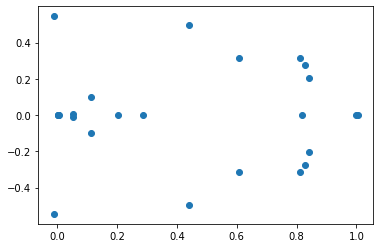

In [43]:
plt.scatter(sorted_eigenvalues.real, sorted_eigenvalues.imag)

/home/guoyue/Koopman4DRP/pk4DRP/lib/python3.8/site-packages/torch/_tensor.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


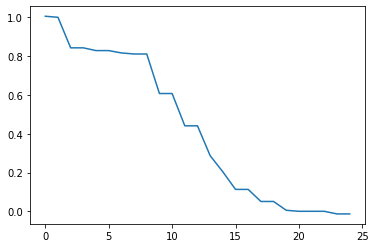

In [42]:
plt.plot(sorted_eigenvalues)

# Evaluation

In [21]:
# def pred_soln(Koopman_model, x0, Nt):
#     Koopman_model.eval()
#     x_pred_list = [x0]
    
#     psi_x0 = Koopman_model.dict(x0)
#     psi_x_pred_list = [psi_x0]
    
#     B = Koopman_model.dict.generate_B(x0)

#     for _ in range(Nt):
#         psi_pred = Koopman_model.model_K(psi_x_pred_list[-1])
#         x_pred = torch.matmul(psi_pred, B)
#         x_pred_list.append(x_pred.detach())
#         psi_x_pred_list.append(psi_pred.detach())
    
#     return torch.stack(x_pred_list, dim=1)


In [44]:
def pred_soln(Koopman_model, x0, Nt):
    Koopman_model.eval()
    x_pred_list = [x0]
    # psi_x0 = Koopman_model.dict(x0)
    # psi_pred = psi_x0
    
    B = Koopman_model.dict.generate_B(x0)
    x_pred = x0

    for _ in range(Nt):
        psi_pred = Koopman_model(x_pred)
        x_pred = torch.matmul(psi_pred, B)
        x_pred_list.append(x_pred.detach())
    
    return torch.stack(x_pred_list, dim=1)


In [45]:
duffing_data_test = duffing.generate_init_data(n_traj=1, traj_len=50, seed=521)
duffing_data_test.shape 

(50, 2)

In [46]:
test_length = 50

In [47]:
duffing_test_pred_iter = pred_soln(Koopman_model=Koopman_model,
                              x0=torch.tensor(duffing_data_test[0]).double().reshape(1,-1),
                              Nt=test_length-1)

In [48]:
# duffing_test_pred = pred_soln(dict=dict_nn,
#                               model_K=model_K,
#                               x0=torch.tensor(duffing_data_curr[0]).double().reshape(1,-1),
#                               Nt=49)

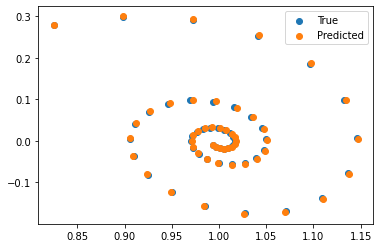

In [49]:
plt.scatter(duffing_data_test[:,0], duffing_data_test[:,1], label='True')
plt.scatter(duffing_test_pred_iter[:,:,0], duffing_test_pred_iter[:,:,1], label='Predicted')
plt.legend()
